In [1]:
#authored by arjun aditham on 08-Feb-2024; this is a crude attempt to navigate datasets and recolor the pre-fusion rabies trimer
#by functional effect scores. 

In [6]:
#This is a crude attempt to rewrite the b-factors with mean functional effect data for rabies glycoprotein trimer. 

import subprocess
import sys

import pandas as pd 
import polyclonal
import numpy as np

In [7]:
#settings for PDB file

input_pdb_file = 'data/7u9g.pdb'
target_chains = ['A','B','C'];


escape_file = 'results/antibody_escape/averages/RVC58_mut_effect.csv';

functional_effects_file = 'results/func_effects/averages/HEK293T_entry_func_effects.csv';

output_pdb_file_name = 'results/7u9g_RVC58.pdb'

#output_file_sub_name = '/results/func_effects/averages/HEK293T_entry_func_effects.csv';

In [8]:
colspecs = [(0, 6), (6, 11), (12, 16), (16, 17), (17, 20), (21, 22), (22, 26),
            (26, 27), (30, 38), (38, 46), (46, 54), (54, 60), (60, 66), (76, 78),
            (78, 80)]

names = ['ATOM', 'serial', 'name', 'altloc', 'resname', 'chainid', 'resseq',
         'icode', 'x', 'y', 'z', 'occupancy', 'tempfactor', 'element', 'charge']

pdb = pd.read_fwf(input_pdb_file, names=names, colspecs=colspecs)

In [9]:
#make subset dataframe that only contains chains of interest--A,B,C (trimer only)
pdb_subsetchains = pdb[pdb['chainid'].isin(target_chains)]

In [5]:
functional_effects_data

NameError: name 'functional_effects_data' is not defined

In [10]:
#get functional effect data
functional_effects_data = pd.read_csv(functional_effects_file)

escape_data = pd.read_csv(escape_file);

#merge data
merged_dfs = pd.merge(escape_data,functional_effects_data,how='left',on=['site','wildtype','mutant'])


#filter by times seen (n>2)
merged_dfs = merged_dfs[merged_dfs['times_seen_x']>=2]
merged_dfs = merged_dfs[merged_dfs['times_seen_x']>=2]

#group by site # to take mean of effect. I'm not going to worry about effect_std rn 
#because the error propagation is going over my head (also idk if that is projected)
merged_dfs_grouped = merged_dfs.groupby('site')


#take mean at every position
def get_mean(df):
    result = df.copy();
    functional_effect_values = result['escape_mean'];

    result['sum_escape']= sum(functional_effect_values);

    return result.reset_index(drop=True);


merged_dfs_grouped= merged_dfs_grouped.apply(get_mean)


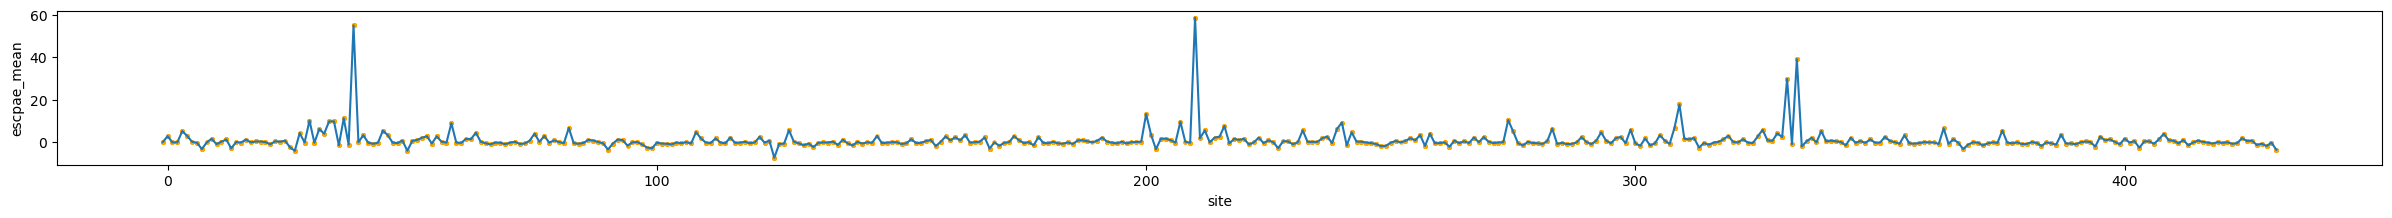

In [11]:

import seaborn as sb
from matplotlib import pyplot as pl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

fig,ax= pl.subplots(figsize=(30,2))
pl.plot(merged_dfs_grouped['site'],merged_dfs_grouped['sum_escape'])
pl.scatter(merged_dfs_grouped['site'],merged_dfs_grouped['sum_escape'],s=5,c='orange')

pl.ylabel('escpae_mean')
pl.xlabel('site')

pl.show()


#okay these seem to indicate that these values are position by position means (best I can tell).

In [17]:
min(merged_dfs_grouped['sum_escape'])

-7.2195651

In [12]:
#I only need 1 mean value per site. So i will just drop duplicates accordingly. 

merged_dfs_grouped = merged_dfs_grouped.drop_duplicates(['site']);

In [13]:
df = pd.DataFrame(columns=['chain','site','mean'])


In [14]:
chain_array=list();
site_array=list();
mean_array=list();

site_list = merged_dfs_grouped['site'].tolist();
means_list = merged_dfs_grouped['sum_escape'].tolist();

for i in target_chains:
    for j in range(0, len(site_list)):
        chain_array.append(i);
        site_array.append(site_list[j]);
        mean_array.append(means_list[j]);
    
        

In [15]:
#okay let's jsut make the df have values now
df['chain']=chain_array;
df['site']=site_array;
df['mean']=mean_array

df

#specific formatting for df
#df = df[~df['site'].str.contains("a|b|c|d|e|f|g")]
df['site'] = df['site'].astype(int)
df=df[df['site']>0];

In [16]:
# save the new PDB file
polyclonal.pdb_utils.reassign_b_factor(input_pdbfile=input_pdb_file, 
                                        output_pdbfile=output_pdb_file_name, 
                                        df=df, 
                                        metric_col='mean')

In [53]:
df[df['site']==333]

,chain,site,mean
334,A,333,39.14151
767,B,333,39.14151
1200,C,333,39.14151


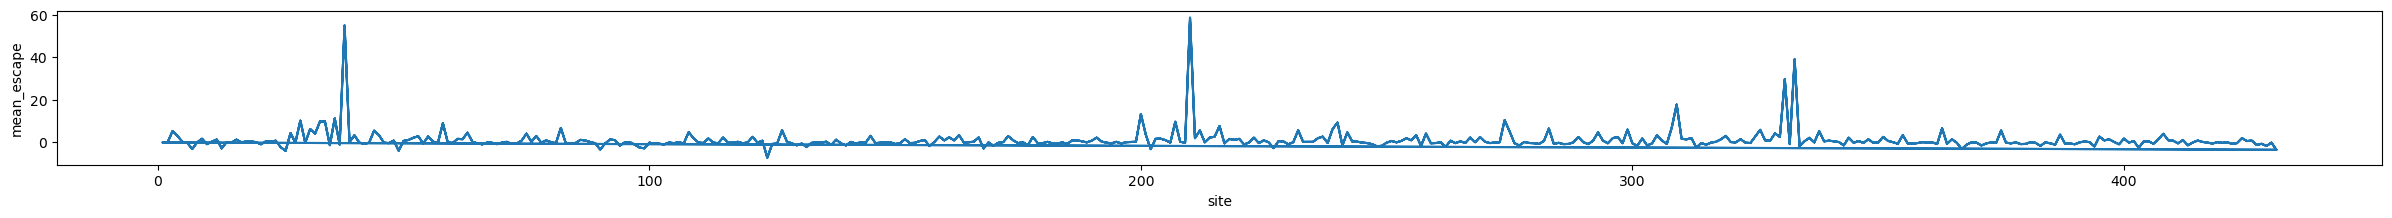

In [52]:
fig,ax= pl.subplots(figsize=(30,2))
pl.plot(df['site'],df['mean'])

pl.ylabel('mean_escape')
pl.xlabel('site')

pl.show()
